ref: https://zenn.dev/tirimen/articles/0c70e82df4add4

ref(code): https://kiseno-log.com/2021/02/03/%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B%E5%9B%9E%E5%B8%B0%E3%82%92python%E3%81%A7%E5%AE%9F%E8%A3%85%E3%81%97%E3%81%A6%E3%81%BF%E3%82%8B/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [15]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
with open("p1_5S11ep=disp.txt") as f:
    text=f.readlines()
sharp_marker=[]

i_read_sharp_before=0
sharp_statements=[]
values=[]
#データをラベル情報を含む#ヘッダーの行とデータのクラスタに分離
for i in range(len(text)):
    if text[i][0]=="#":
        if i_read_sharp_before==0:
            if i!=0:
                sharp_statements.append(sharp_statement)
                values.append(value)
            sharp_statement=[]
            value=[]
        sharp_statement.append(text[i])
        i_read_sharp_before=1
    else:
        value.append(text[i])
        i_read_sharp_before=0

#データのクラスタについてさらに分離
freqs=[]
magns=[]
phass=[]
for i in range(len(values)):
    freq=[]
    magn=[]
    phas=[]
    for j in range(len(values[i])):
        val_data=values[i][j].replace("\n","").split("\t")
        freq.append(float(val_data[0]))
        magn.append(float(val_data[1]))
        phas.append(float(val_data[2]))
    freqs.append(freq)
    magns.append(magn)
    phass.append(phas)

In [3]:
height=[]
rad=[]

for j in range(len(sharp_statements)):
    value=sharp_statements[i][0][15:].split(";")
    for i in range(len(value)):
        if i == len(value)-1:
            val_label=value[i].split("=")[0]
            val=float(value[i].split("=")[1][:-2])
        else:
            val_label=value[i].split("=")[0]
            val=float(value[i].split("=")[1])
        if i==0:
            for l in range(len(freqs[j])):
                height.append(val)
        elif i==2:
            for l in range(len(freqs[j])):
                rad.append(val)

学習データを形成する。今回は周波数、膜厚、半径を用いて位相を推定するモデルを構築する。

In [4]:
freqs_flat=list(itertools.chain.from_iterable(freqs))
magns_flat=list(itertools.chain.from_iterable(magns))
phass_flat=list(itertools.chain.from_iterable(phass))

len(freqs_flat),len(magns_flat),len(phass_flat),len(height),len(rad)

(10792, 10792, 10792, 10792, 10792)

10792個のデータがあるので、個の中の8割を学習に用いて2割をテストに用いる。

In [5]:
import random

In [6]:
num_data=len(freqs_flat)
num_train=int(len(freqs_flat)*0.8)

index_list=random.sample(range(num_data-1), k=num_train)

In [7]:
freq_train=[]
magn_train=[]
phas_train=[]
heig_train=[]
radi_train=[]

freq_test=[]
magn_test=[]
phas_test=[]
heig_test=[]
radi_test=[]

for i in range(num_data):
    if i in index_list:
        freq_train.append(freqs_flat[i])
        magn_train.append(magns_flat[i])
        phas_train.append(phass_flat[i])
        heig_train.append(height[i])
        radi_train.append(rad[i])
    else:
        freq_test.append(freqs_flat[i])
        magn_test.append(magns_flat[i])
        phas_test.append(phass_flat[i])
        heig_test.append(height[i])
        radi_test.append(rad[i])


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

class kernel:
    def __init__(self, s1=1.0, s2=1.0, s3=0.1):
        self.s1, self.s2, self.s3 = s1,s2,s3

    def rbf_white(self,x, x_p,i=1):
        """カーネル計算"""
        # cdist:n-ベクトル間のユークリッド距離
        if i ==1:
            k =  self.s1 * np.exp(-1.0 * cdist(x, x_p, 'sqeuclidean')/self.s2) + (self.s3 * np.eye(x.shape[0]))
        else:
            k =  self.s1 * np.exp(-1.0 * cdist(x, x_p, 'sqeuclidean')/self.s2) 
        return k
    


# サンプルデータの作成
x_train=[]
x_test=[]
for i in range(num_train):
    x_train.append([freq_train[i],heig_train[i],radi_train[i]] )# 学習データ
for i in range(len(freq_test)):
    x_test.append([freq_test[i],heig_test[i],radi_test[i]]) # テストデータ

y_train = np.array(phas_train)

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel

regr = GaussianProcessRegressor(
    kernel=ConstantKernel()* RBF() + WhiteKernel(),  # カーネルの演算については後述
    alpha=0.,  # 雑音項はカーネルの中で表現しているので 0. を指定
    # optimizer=None,
)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.gaussian_process as gp
%matplotlib inline
plt.rcParams['font.size']=15

def plt_legend_out(frameon=True):
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=frameon)


In [18]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_absolute_error


max_depth = 5
min_child_weight = 10
subsample = 0.5
colsample_bytree = 0.6
objective = 'reg:linear'
num_estimators = 1000
learning_rate = 0.3

model = xgb.XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
    n_estimators=num_estimators,
)
model.fit(x_train, y_train, eval_set=[(x_train, y_train)])

[0]	validation_0-rmse:85.47249	validation_0-mean_absolute_error:66.79290
[1]	validation_0-rmse:84.38869	validation_0-mean_absolute_error:65.57993
[2]	validation_0-rmse:83.84500	validation_0-mean_absolute_error:64.90405
[3]	validation_0-rmse:83.56189	validation_0-mean_absolute_error:64.54284
[4]	validation_0-rmse:83.41766	validation_0-mean_absolute_error:64.32825
[5]	validation_0-rmse:83.32675	validation_0-mean_absolute_error:64.19059
[6]	validation_0-rmse:83.27905	validation_0-mean_absolute_error:64.11179
[7]	validation_0-rmse:83.25231	validation_0-mean_absolute_error:64.06435
[8]	validation_0-rmse:83.23762	validation_0-mean_absolute_error:64.02731
[9]	validation_0-rmse:83.22860	validation_0-mean_absolute_error:64.00223
[10]	validation_0-rmse:83.22187	validation_0-mean_absolute_error:63.98821
[11]	validation_0-rmse:83.21634	validation_0-mean_absolute_error:63.97654
[12]	validation_0-rmse:83.21357	validation_0-mean_absolute_error:63.96817
[13]	validation_0-rmse:83.21104	validation_0-mea

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7eb948597010>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'rad[um]')

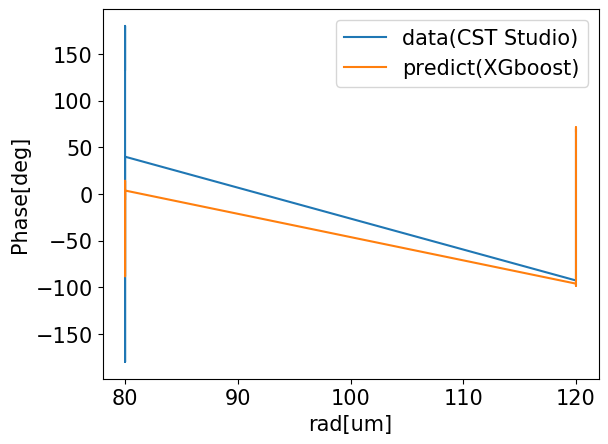

In [19]:


# テストデータを与えて各データの種類を推測
pred = model.predict(x_test)

plt.plot(radi_test,phas_test,label="data(CST Studio)")
plt.plot(radi_test,pred,label="predict(XGboost)")
plt.legend()

plt.ylabel("Phase[deg]")
plt.xlabel("rad[um]")

Text(0.5, 0, 'rad[um]')

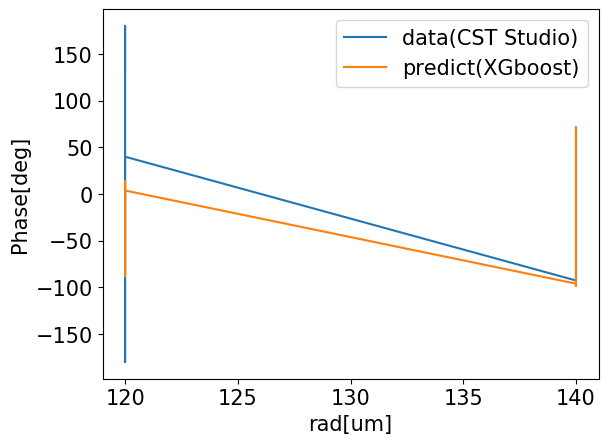

In [20]:
plt.plot(heig_test,phas_test,label="data(CST Studio)")
plt.plot(heig_test,pred,label="predict(XGboost)")
plt.legend()

plt.ylabel("Phase[deg]")
plt.xlabel("rad[um]")